Goal of this code is to demonstrate sequential processing (processing of sequences) by RNNs, using the MNIST data set as a toy example. Rather than processing the entire image in one go, we'll process them as sequences of rows of pixels, starting from the top of the image and moving down.

Processing on: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 59.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


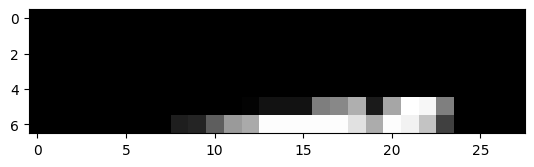

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from torch import nn
import random
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Processing on:", device)

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

train_x = mnist_trainset.data / 256.0 - 0.5
train_y = mnist_trainset.targets

test_x = mnist_testset.data / 256.0 - 0.5
test_y = mnist_testset.targets

example_image = train_x[0]

fig = plt.figure
plt.imshow(example_image[0:7,:], cmap='gray') # Showing the first 7 rows of image 0, which is a 5
plt.show()

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

train_dataset = data.TensorDataset(train_x, train_y)

batch_size = 64
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

The following model will take a stack of pixel rows, and process the rows one at a time, building a 50-dimensional 'memory' vector as it goes, and then use the memory of everything it's seen to try to classify the image. Note, the choice of 50 here is arbitrary.

In [2]:
class SeqMNIST_Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.process_current_row = torch.nn.Linear( in_features = 28, out_features = 50, bias = True )
    # Linear function for mapping a 28-dimensional row of pixels into the 50-dimensional memory-space
    # Note, bias is true here so this will include the bias vector

    self.process_current_memory = torch.nn.Linear( in_features = 50, out_features = 50, bias = False )
    # Linear function for processing the 50-dimensional memory vector (to combine it with the new row of pixels)
    # And produce an updated memory vector
    # Note bias is false here, because we are going to do self.process_current_row( current_row ) + self.process_current_memory( current_memory ),
    # And I only need to include the bias vector from one of them.

    self.final_logit_layer = torch.nn.Linear( in_features = 50, out_features = 10, bias = True )
    # At any point, we can take the current 50-dimensional memory vector,
    # apply a linear function, and get a vector of logits for classification

  def forward(self, input_tensor):
    # input shape : (# num data points) x (# rows) x (28)
    row_count = input_tensor.shape[1]

    current_memory = torch.zeros( input_tensor.shape[0], 50 ) # Initialize a 50-dimensional vector of 0s for the initial (blank) memory
    current_memory = current_memory.to( device ) # Making illegal use of device as a global variable here, bad coding practice, don't do this

    for i in range( row_count ):

      current_row = input_tensor[:,i,:] # grabs the 0-th row of each image

      new_memory = torch.nn.Sigmoid()( self.process_current_row( current_row ) + self.process_current_memory( current_memory ) )

      current_memory = new_memory

    output = self.final_logit_layer( current_memory )
    return output

In [3]:
model = SeqMNIST_Model()
model = model.to( device )

Standard Confusion Matrix calculation, taking the maximum logit as the predicted (most likely) class. Note I'm also tracking the number of correct classifications (on the diagonal) to get the accuracy of the model.

In [4]:
def confusion_matrix( model, x, y ):
  total_ids = 0
  identification_counts = np.zeros( shape = (10,10), dtype = np.int32 )
  logits = model( x )
  predicted_classes = torch.argmax( logits, dim = 1 )

  n = x.shape[0]

  for i in range(n):
    actual_class = int( y[i].item() )
    predicted_class = predicted_classes[i].item()
    identification_counts[actual_class, predicted_class] += 1
    total_ids += 1

  correct_ids = 0
  for i in range(10):
    correct_ids += identification_counts[i, i]

  return identification_counts, correct_ids / total_ids

In [5]:
confusion_matrix( model, test_x, test_y )

(array([[   0,    0,  980,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0, 1135,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0, 1032,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0, 1010,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,  982,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,  892,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,  958,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0, 1028,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,  974,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0, 1009,    0,    0,    0,    0,    0,    0,    0]],
       dtype=int32),
 np.float64(0.1032))

In what follows, I'm computing the accuracy of the model on the test data and the training data - but importantly, only looking at the first k rows of data. This gives a sense of how the model improves as it process more of the image. OF course, since the model is not trained at the start, it's basically doing random guessing, and gets an accuracy of about 10% as expected.

In [6]:
test_accuracy = [ confusion_matrix( model, test_x[:, 0:k, :], test_y )[1] for k in range(1,28+1) ]
train_accuracy = [ confusion_matrix( model, train_x[:, 0:k, :], train_y )[1] for k in range(1,28+1) ]

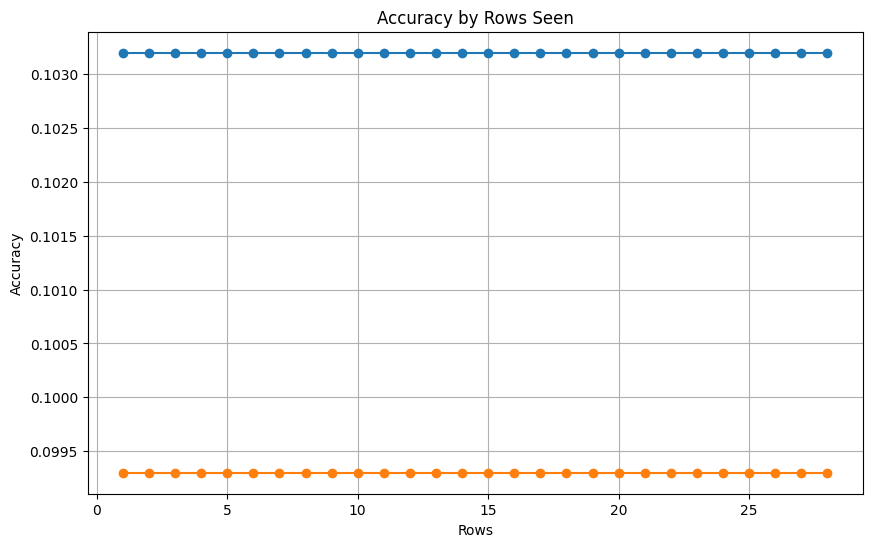

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_accuracy) + 1), test_accuracy, marker='o', linestyle='-')
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, marker='o', linestyle='-')
plt.title("Accuracy by Rows Seen")
plt.xlabel("Rows")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [8]:
loss_function = torch.nn.CrossEntropyLoss()

In [9]:
optimizer = optim.Adam( model.parameters(), lr = 0.001 )

Standard training loop - only thing new is that I'm grabbing a random number of rows of each batch. This guarantees diversity of the training data - the model is exposed to samples of various lengths, and doesn't learn to rely on seeing the whole image.

In [10]:
for epoch in range(10):
  total_loss = 0
  for x_batch, y_batch in train_loader:
    row_count = random.randint(1,28+1)
    x_batch = x_batch[:, 0:row_count, :]

    logits = model( x_batch )
    loss = loss_function( logits, y_batch )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  avg_loss = total_loss / len( train_loader )

  print(f"Epoch {epoch+1}, Average Loss:{avg_loss:0.6f}")

Epoch 1, Average Loss:2.237528
Epoch 2, Average Loss:2.116156
Epoch 3, Average Loss:2.057334
Epoch 4, Average Loss:2.028856
Epoch 5, Average Loss:2.016537
Epoch 6, Average Loss:1.960959
Epoch 7, Average Loss:1.959518
Epoch 8, Average Loss:1.911461
Epoch 9, Average Loss:1.903464
Epoch 10, Average Loss:1.850140


In [11]:
test_accuracy = [ confusion_matrix( model, test_x[:, 0:k, :], test_y )[1] for k in range(1,28+1) ]
train_accuracy = [ confusion_matrix( model, train_x[:, 0:k, :], train_y )[1] for k in range(1,28+1) ]

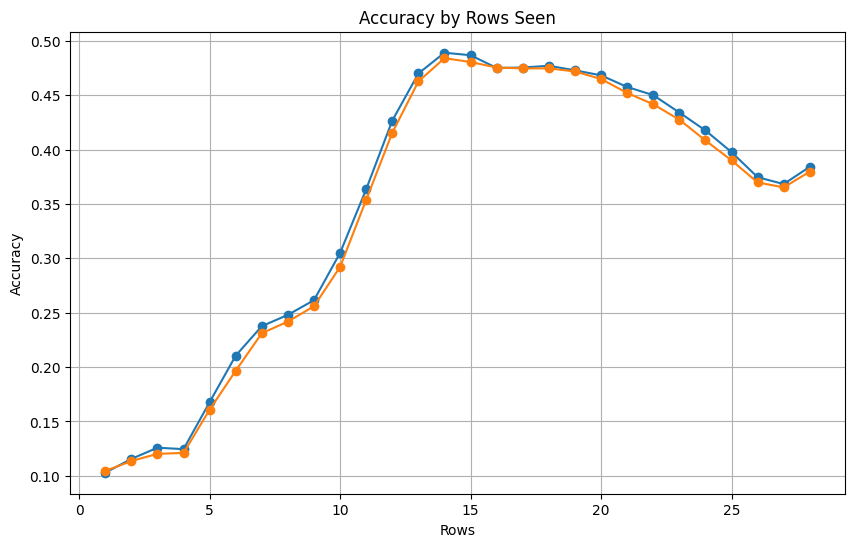

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_accuracy) + 1), test_accuracy, marker='o', linestyle='-')
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, marker='o', linestyle='-')
plt.title("Accuracy by Rows Seen")
plt.xlabel("Rows")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In the above, we see obvious improvement. Starting at 10% when seeing 1 row (random guess), the model steadily improves in accuracy as it sees more of the image, peaking at about the half way point. Note that we reach almost 50% accuracy, much better than random guessing. The decline past this point is interesting, I attribute it to two things - first, most of the batches the model is trained on will have less than 3/4ths of the rows available, so it's seeing bigger slices of the image less often. Second, as the tail end of the images are mostly blank, this has the effect of washing out a lot of the computed memory of everything so far. But further training improves the picture.

In [13]:
for epoch in range(10):
  total_loss = 0
  for x_batch, y_batch in train_loader:
    row_count = random.randint(1,28+1)
    x_batch = x_batch[:, 0:row_count, :]

    logits = model( x_batch )
    loss = loss_function( logits, y_batch )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  avg_loss = total_loss / len( train_loader )

  print(f"Epoch {epoch+1}, Average Loss:{avg_loss:0.6f}")

Epoch 1, Average Loss:1.809546
Epoch 2, Average Loss:1.761783
Epoch 3, Average Loss:1.714973
Epoch 4, Average Loss:1.705617
Epoch 5, Average Loss:1.636923
Epoch 6, Average Loss:1.615693
Epoch 7, Average Loss:1.592948
Epoch 8, Average Loss:1.549787
Epoch 9, Average Loss:1.529549
Epoch 10, Average Loss:1.512557


In [14]:
test_accuracy = [ confusion_matrix( model, test_x[:, 0:k, :], test_y )[1] for k in range(1,28+1) ]
train_accuracy = [ confusion_matrix( model, train_x[:, 0:k, :], train_y )[1] for k in range(1,28+1) ]

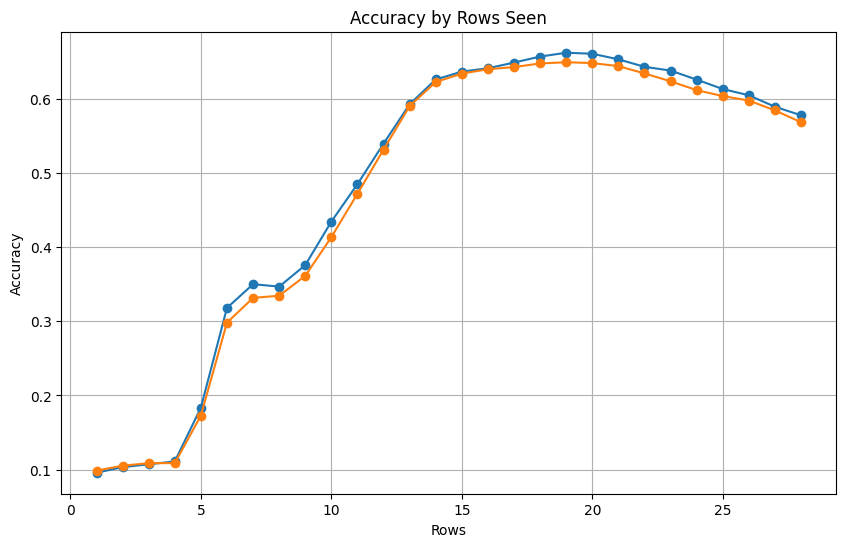

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_accuracy) + 1), test_accuracy, marker='o', linestyle='-')
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, marker='o', linestyle='-')
plt.title("Accuracy by Rows Seen")
plt.xlabel("Rows")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

The picture continues to improve.

In what follows, instead of doing the RNN computation 'by hand' with a loop in the forward method, I use the RNN module, documentation available here: https://docs.pytorch.org/docs/stable/generated/torch.nn.RNN.html

Note, one thing that this is doing differently: instead of doing a sigmoid activation, it is doing a Tanh activation. There are also options for doing dropout internally, which I am not using here.

Important notes about the RNN module:
- Default output is two things, the /full sequence/ of memory vectors
- And the final memory or 'state' vector
- However, because the default RNN module can be 'stacked' (multiple RNNs feeding their sequences of memory vectors into the next), this is returned as a collection of memory sequences and last states, one for each stacked RNN.

This is not really an issue for us here, but we do need to just grab the last state vector to use in our logit layer.

In [16]:
class RNN_MNIST_Model(nn.Module):
  def __init__(self):
    super(RNN_MNIST_Model, self).__init__()

    self.rnn = torch.nn.RNN(input_size = 28, hidden_size = 50, bias=True, batch_first = True )

    self.final_logit_layer = torch.nn.Linear( in_features = 50, out_features = 10, bias = True )


  def forward(self, input_tensor, verbose = False):

    seq_output, last_states = self.rnn( input_tensor )

    if verbose:
      print("Sequence Output Shape:", seq_output.shape ) # For each data point, we should have [ row count ] many vectors of size 50
      print("Last States:", last_states.shape) # This should return a collection of 50-dimensional vectors, one for each data point

    output = last_states[0] # If we had multiple RNNs on top of each other, last_states would store the last memory vector from each RNN
                              # We just need the one

    if verbose:
      print("Taking Last States:", output.shape )

    output = self.final_logit_layer( output ) # Pass that final state vector into the logit layer

    if verbose:
      print("Final Output Shape:", output.shape)

    return output # Final predictions

rnn_model = RNN_MNIST_Model()
rnn_model = rnn_model.to( device )
output = rnn_model( train_x[:, 0:14, :], verbose = True )
output.shape

Sequence Output Shape: torch.Size([60000, 14, 50])
Last States: torch.Size([1, 60000, 50])
Taking Last States: torch.Size([60000, 50])
Final Output Shape: torch.Size([60000, 10])


torch.Size([60000, 10])

In [17]:
rnn_optimizer = optim.Adam( rnn_model.parameters(), lr = 0.001 )

We've changed the model, but all the important computational changes happen within the module itself - the training loop is unchanged.

In [18]:
for epoch in range(10):
  total_loss = 0
  for x_batch, y_batch in train_loader:
    row_count = random.randint(1,28+1)
    x_batch = x_batch[:, 0:row_count, :]

    logits = rnn_model( x_batch )
    loss = loss_function( logits, y_batch )

    rnn_optimizer.zero_grad()
    loss.backward()
    rnn_optimizer.step()

    total_loss += loss.item()

  avg_loss = total_loss / len( train_loader )

  print(f"Epoch {epoch+1}, Average Loss:{avg_loss:0.6f}")

Epoch 1, Average Loss:2.021762
Epoch 2, Average Loss:1.677609
Epoch 3, Average Loss:1.418536
Epoch 4, Average Loss:1.270001
Epoch 5, Average Loss:1.173242
Epoch 6, Average Loss:1.131869
Epoch 7, Average Loss:1.073379
Epoch 8, Average Loss:1.060732
Epoch 9, Average Loss:1.002499
Epoch 10, Average Loss:0.965200


Improved convergence in 10 epochs. Since I used the linear layers to generate my weight matrices previously, I think this is primarily due to the shift to tanh as the default activation, but that would require more investigation to check.

In [19]:
test_accuracy = [ confusion_matrix( rnn_model, test_x[:, 0:k, :], test_y )[1] for k in range(1,28+1) ]
train_accuracy = [ confusion_matrix( rnn_model, train_x[:, 0:k, :], train_y )[1] for k in range(1,28+1) ]

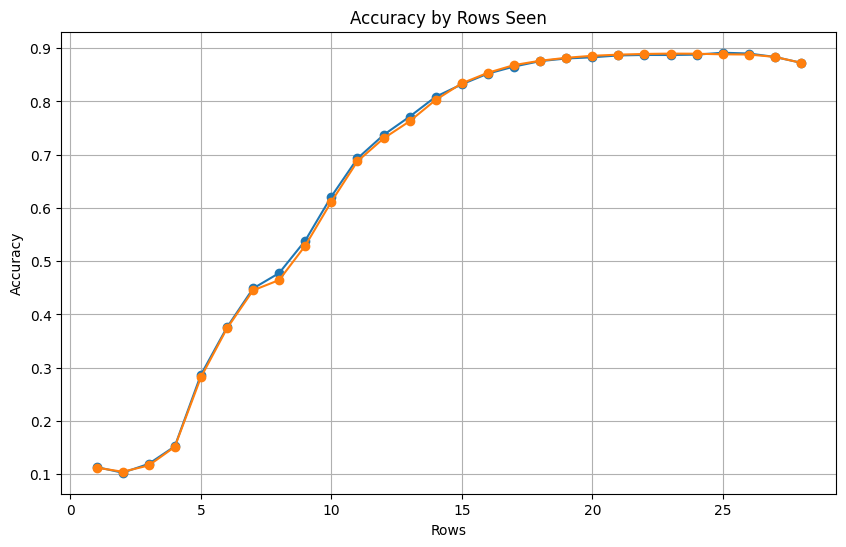

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_accuracy) + 1), test_accuracy, marker='o', linestyle='-')
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, marker='o', linestyle='-')
plt.title("Accuracy by Rows Seen")
plt.xlabel("Rows")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

General improvement. Still slight decay towards the end - I'm still attributing that to the last blank pixel rows wiping stored memory. One way of understanding that - the model hasn't learned the best way to process blank rows into its memory vector yet.

In [21]:
for epoch in range(20):
  total_loss = 0
  for x_batch, y_batch in train_loader:
    row_count = random.randint(1,28+1)
    x_batch = x_batch[:, 0:row_count, :]

    logits = rnn_model( x_batch )
    loss = loss_function( logits, y_batch )

    rnn_optimizer.zero_grad()
    loss.backward()
    rnn_optimizer.step()

    total_loss += loss.item()

  avg_loss = total_loss / len( train_loader )

  print(f"Epoch {epoch+1}, Average Loss:{avg_loss:0.6f}")

Epoch 1, Average Loss:1.026599
Epoch 2, Average Loss:0.966283
Epoch 3, Average Loss:0.998180
Epoch 4, Average Loss:0.945569
Epoch 5, Average Loss:0.914156
Epoch 6, Average Loss:0.946651
Epoch 7, Average Loss:0.917125
Epoch 8, Average Loss:0.937102
Epoch 9, Average Loss:0.906952
Epoch 10, Average Loss:0.884824
Epoch 11, Average Loss:0.926052
Epoch 12, Average Loss:0.895734
Epoch 13, Average Loss:0.877441
Epoch 14, Average Loss:0.899892
Epoch 15, Average Loss:0.849764
Epoch 16, Average Loss:0.837682
Epoch 17, Average Loss:0.874176
Epoch 18, Average Loss:0.859764
Epoch 19, Average Loss:0.825097
Epoch 20, Average Loss:0.861470


In [22]:
test_accuracy = [ confusion_matrix( rnn_model, test_x[:, 0:k, :], test_y )[1] for k in range(1,28+1) ]
train_accuracy = [ confusion_matrix( rnn_model, train_x[:, 0:k, :], train_y )[1] for k in range(1,28+1) ]

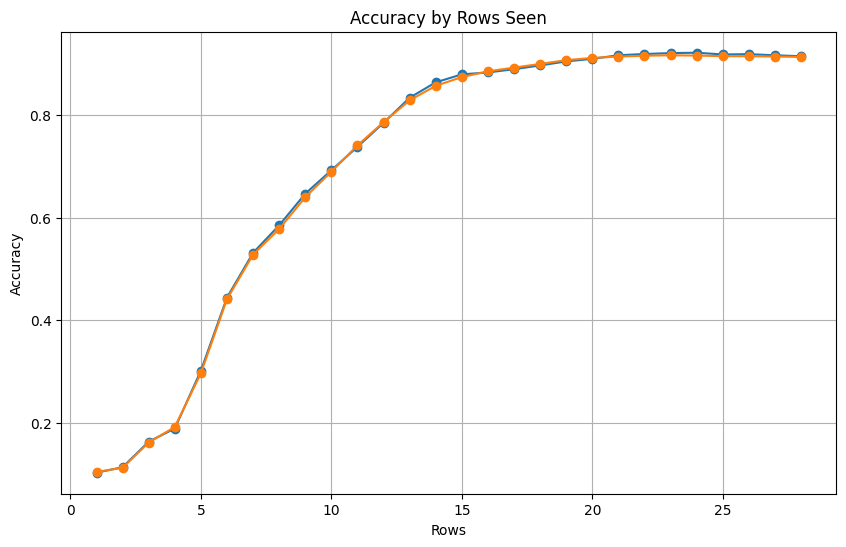

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_accuracy) + 1), test_accuracy, marker='o', linestyle='-')
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, marker='o', linestyle='-')
plt.title("Accuracy by Rows Seen")
plt.xlabel("Rows")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

Nice.